### + Folder "process" gồm các file chính:
- analysis.py: Phân tích, xử lý các message nhận được từ "scraper.py".
- models.py: Định nghĩa ra các model dữ liệu ở trong database.
- .env: Lưu trữ các environment variables.
- settings.py: Lấy ra các giá trị các biến trong file .env và gán vào các biến trong python.

### + Folder này là phần "Data Analysis/Transformation" trong ảnh dưới
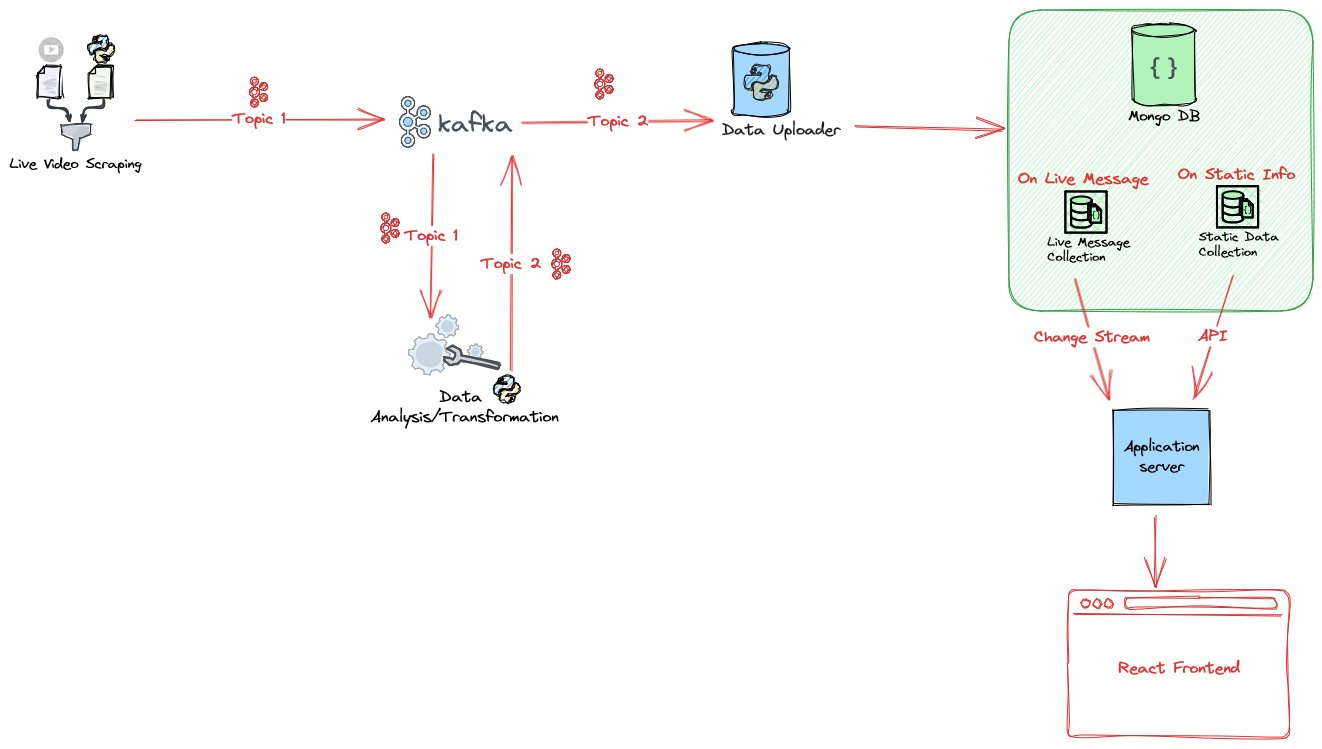

### + .env: Gồm 3 biến
- KAFKA_SERVER: URL kết nối tới server kafka.
- TRANSFORM_CONSUME_TOPIC: tên topic của consumer.
- TRANSFORM_PRODUCE_TOPIC: tên topic của producer.

    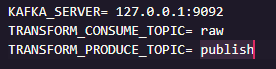

### + settings.py: Lấy ra giá trị các biến được khai báo trong file .env và lưu trữ các giá trị đó vào các biến python.
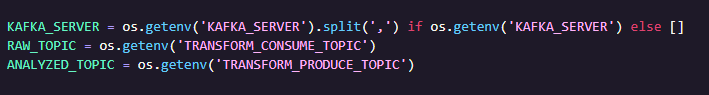

### + models.py: Định nghĩa các model dữ liệu và các class Enum, các model dữ liệu này được định nghĩa theo các collection của database.

- Các Enum class:
    - InfoType(Enum): Có 2 loại info sẽ nhận được từ "scraper.py":
        - VIDEO_STATIC_INFO: thông tin của video đang live (tên video, url, thumbnail, thời gian, ....)
        - VIDEO_LIVE_MESSAGE: thông tin của các live chat (tên người gửi, thời gian, nội dung, ....)

            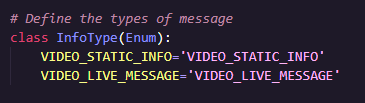

    - SentimentType(Enum): Có 3 loại sentiment được phân loại từ live chat:
        - POSITIVE: Tích cực
        - NEGATIVE: Tiêu cực
        - NEUTRAL: Trung bình

            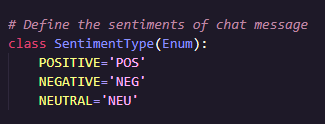

    
- Các model class:
    - BaseDataClass: Là class cha của các class model, class này không có thuộc tính gì mà chỉ để định nghĩa các hàm chung như to_dict(self), to_json(self).
    
        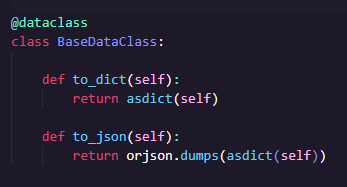

    - VideoStaticInfo(BaseDataClass): Là model được định nghĩa từ collection "info" trong database và kế thừa BaseDataClass, gồm những trường thông tin, thuộc tính sau:
        - channel_name: tên channel của video đang live.
        - channel_url: URL đến channel đó.
        - channel_category: thể loại channel.
        - video_id: id của video đang live.
        - video_title: Tiêu đề video.
        - video_url: URL đến video đang live.
        - video_thumbnail_url: URL đến thumbnail của video.
        - is_live: Trạng thái của video (Có live hay không).
        - info_type: model này có thông tin thuộc loại VIDEO_STATIC_INFO.
        - timestamp: Mốc thời gian mà đối tượng VideoStaticInfo này được tạo ra.

        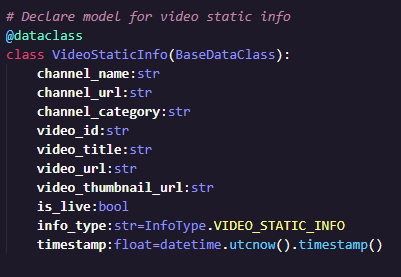

    - VideoLiveMessage(BaseDataClass): Là model được định nghĩa từ collection "message" trong database và kế thừa BaseDataClass, gồm những trường thông tin, thuộc tính sau:
        - video_id: id của video đang live.
        - viewers_count: lượng view hiện tại của video.
        - is_live: Trạng thái của video (Có live hay không).
        - message_time_usec: Thời gian biểu thị dưới dạng microsecond mà live chat được đăng lên.
        - message_dt: ngày giờ live chat được đăng lên.
        - message_author_name: tác giả của đoạn chat đó.
        - message_content: thông tin của đoạn chat.
        - inferred_sentiment: sentiment của đoạn chat đó.
        - has_profanity: Có chứa từ ngữ tục tĩu hay không (Chưa làm được).
        - timestamp: Mốc thời gian.
        - info_type: model này có thông tin thuộc loại VIDEO_LIVE_MESSAGE.

        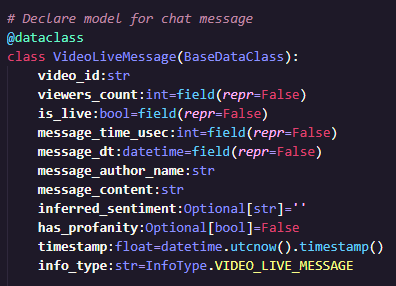

### + analysis.py: File này dùng để xử lý, phân tích các message nhận được từ file cào web "scraper.py".

- File gồm 1 class Analyser:
    - Gồm những thuộc tính chính sau:
        - consumer: Khởi tạo nên đối tượng KafkaConsumer.
        - producer: Khởi tạo nên đối tượng KafkaProducer.
    
    - Gồm những hàm chính sau:
        - __start_consumer(self): Thuộc tính consumer được khai báo ở trong hàm này. Consumer topic sẽ nhận những message gửi đến từ file "scraper.py"

            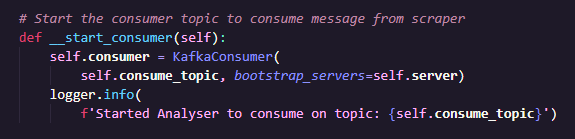

        - __start_producer(self): Thuộc tính producer được khai báo ở trong hàm này. Producer topic này sẽ gửi những message đã được xử lý trong file này đi.

            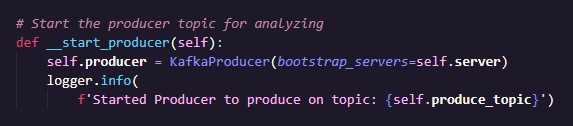
            
        - receive_upstream(self): Lấy ra những raw message ở dạng bytes từ consumer.

            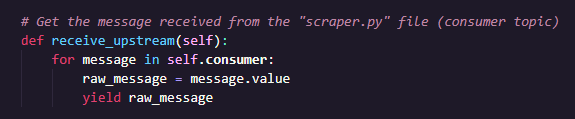

        - get_sentiment(self, message): Nhận vào message và thực hiện đánh giá điểm sentiment để cho ra SentimentType:
            - Trong đó: 
                - message: Nội dung của đoạn live chat.
            - Nếu điểm >= 0.05 --> Positive
            - Nếu điểm <= -0.05 --> Negative.
            - Còn lại --> Neutral.

            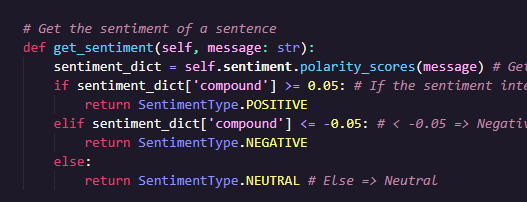

        - process_message(self, raw_msg): 
            1. Xử lý raw_msg ra định dạng json và phân loại message, nếu message thuộc loại "VIDEO_STATIC_INFO" thì trả về raw_message được truyền vào.
            2. Xử lý nội dung của đoạn chat và đánh giá điểm sentiment để lấy ra SentimentType của đoạn chat đó.
            3. Trả về message đã được update thuộc tính "inferred_sentiment".
            
            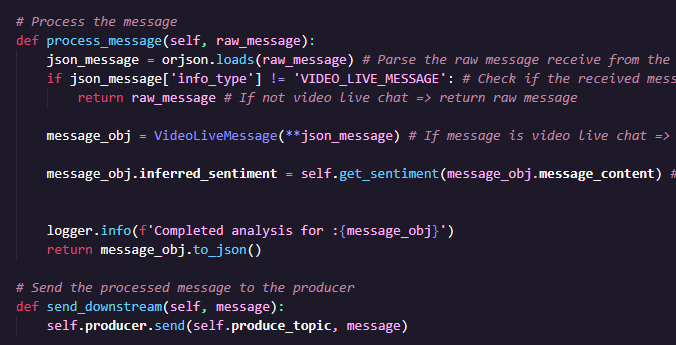

        - send_downstream(self, msg):
            - Gửi msg đến producer.

            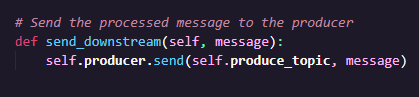

        - __start_session(self): Bắt đầu chuỗi tiến trình theo thứ tự sau:
            1. Khởi động consumer.
            2. Khởi động producer.
            3. Bắt đầu phân tích các message nhận được từ consumer.
            4. Gửi những tin nhắn đã phân tích xuống producer.

            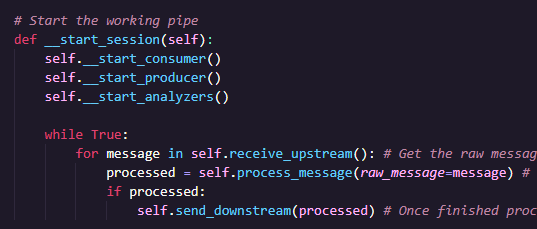
